In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Bidirectional, LSTM, Dense

In [40]:
df = pd.read_csv('/kaggle/input/gold-price-prediction-dataset/FINAL_USO.csv', parse_dates=['Date'], index_col=['Date'])

In [41]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,SP_close,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,122.180000,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,121.589996,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,120.290001,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,123.930000,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,124.169998,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1718 entries, 2011-12-15 to 2018-12-31
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           1718 non-null   float64
 1   High           1718 non-null   float64
 2   Low            1718 non-null   float64
 3   Close          1718 non-null   float64
 4   Adj Close      1718 non-null   float64
 5   Volume         1718 non-null   int64  
 6   SP_open        1718 non-null   float64
 7   SP_high        1718 non-null   float64
 8   SP_low         1718 non-null   float64
 9   SP_close       1718 non-null   float64
 10  SP_Ajclose     1718 non-null   float64
 11  SP_volume      1718 non-null   int64  
 12  DJ_open        1718 non-null   float64
 13  DJ_high        1718 non-null   float64
 14  DJ_low         1718 non-null   float64
 15  DJ_close       1718 non-null   float64
 16  DJ_Ajclose     1718 non-null   float64
 17  DJ_volume      1718 non-null   int

In [43]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [44]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 3])  # Predicting 'Close' price
    return np.array(X), np.array(y)

In [45]:
train_size = int(len(df) * 0.9)
validation_size = int(train_size * 0.05)
test_size = int(train_size * 0.05)

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + validation_size]
test_data = scaled_data[train_size + validation_size:train_size + validation_size + test_size]

In [46]:
window_size = 31
input_features = 80

X_train, y_train = create_sequences(train_data, window_size)
X_val, y_val = create_sequences(val_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

In [54]:
from tensorflow.keras import backend as K

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Custom R-squared (coefficient of determination) metric
def r2_score(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

In [55]:
model = Sequential()

# --- Convolutional Block ---
# First convolutional layer with input shape
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same',
                 input_shape=(window_size, input_features)))
model.add(BatchNormalization())

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'))
model.add(BatchNormalization())

# Optionally add a Dropout layer after convolutions
model.add(Dropout(0.2))

# --- LSTM Block ---
# Using Bidirectional LSTM to capture sequence information
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))

# --- Fully Connected Block with 10 additional Dense layers ---
# You can adjust the number of units or dropout rates as desired.
dense_units = [256, 256, 128, 128, 128, 64, 64, 32, 32, 16]
for units in dense_units:
    model.add(Dense(units, activation='relu'))
    model.add(BatchNormalization())
    # Use a slightly higher dropout for larger layers, lower for smaller ones
    model.add(Dropout(0.3 if units >= 128 else 0.2))

# --- Output Layer ---
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        'mae',         # Mean Absolute Error (built-in)
        rmse,          # Custom RMSE
        'mape',        # Mean Absolute Percentage Error (built-in)
        'msle',        # Mean Squared Logarithmic Error (built-in)
        r2_score       # Custom R-squared metric
    ]
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 31, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 31, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 31, 128)             │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 31, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 31, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 410,465 (1.57 MB)

 Trainable params: 407,873 (1.56 MB)

 Non-trainable params: 2,592 (10.12 KB)

In [60]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 1.0694 - mae: 0.7875 - mape: 521.4749 - msle: 0.1603 - r2_score: -112.2616 - rmse: 1.2971 - val_loss: 0.1023 - val_mae: 0.2811 - val_mape: 48.6930 - val_msle: 0.0000e+00 - val_r2_score: -186.9852 - val_rmse: 0.3118
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.9049 - mae: 0.7211 - mape: 518.5828 - msle: 0.1376 - r2_score: -111.2500 - rmse: 1.3168 - val_loss: 0.0950 - val_mae: 0.2710 - val_mape: 47.3675 - val_msle: 0.0000e+00 - val_r2_score: -172.0241 - val_rmse: 0.2992
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.8930 - mae: 0.7205 - mape: 756.5505 - msle: 0.1202 - r2_score: -117.2214 - rmse: 1.3338 - val_loss: 0.0678 - val_mae: 0.2256 - val_mape: 39.9287 - val_msle: 0.0000e+00 - val_r2_score: -124.6507 - val_rmse: 0.2549
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.8080 - mae: 0.6704 - mape: 304.8432 - msle: 0.1229 - r2_score: -116.6065 - rmse: 1.3188 - val_loss: 0.0634 - val_mae:

In [61]:
test_loss, test_mae, test_rmse, test_mape, test_msle, test_r2 = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAPE: {test_mape}")
print(f"Test MSLE: {test_msle}")
print(f"Test R2 Score: {test_r2}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1909 - mae: 0.4250 - mape: 60.3878 - msle: 0.0000e+00 - r2_score: -1013.0722 - rmse: 0.4180
Test Loss: 0.18166007101535797
Test MAE: 0.41429850459098816
Test RMSE: 0.39935389161109924
Test MAPE: 59.0570068359375
Test MSLE: 0.0
Test R2 Score: -1064.68212890625


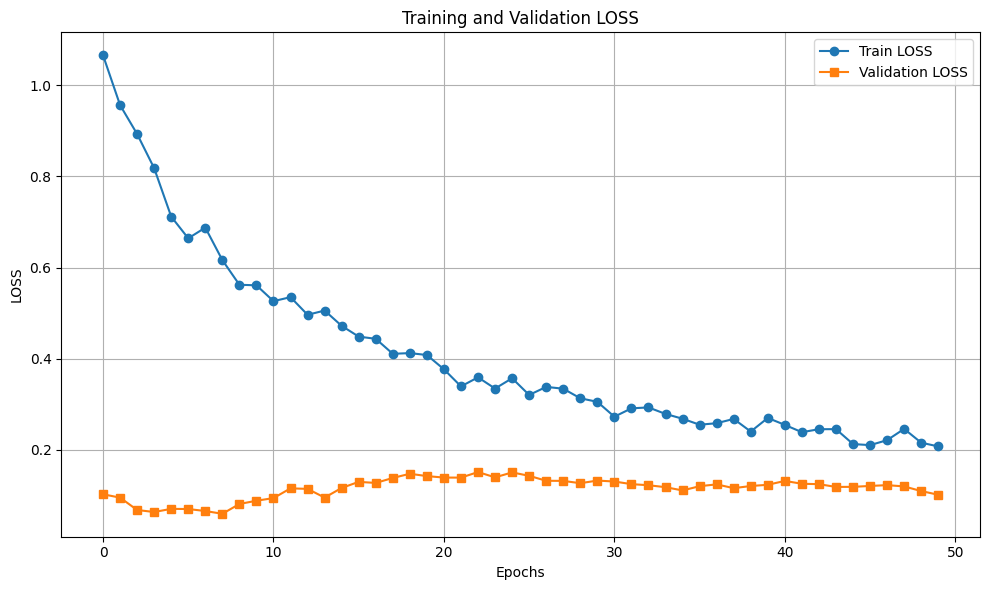

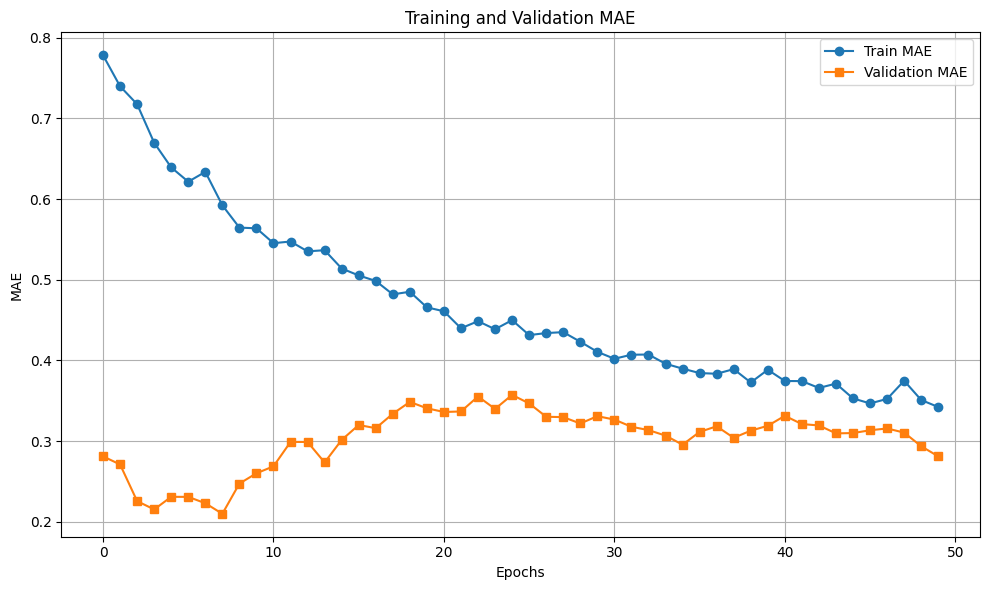

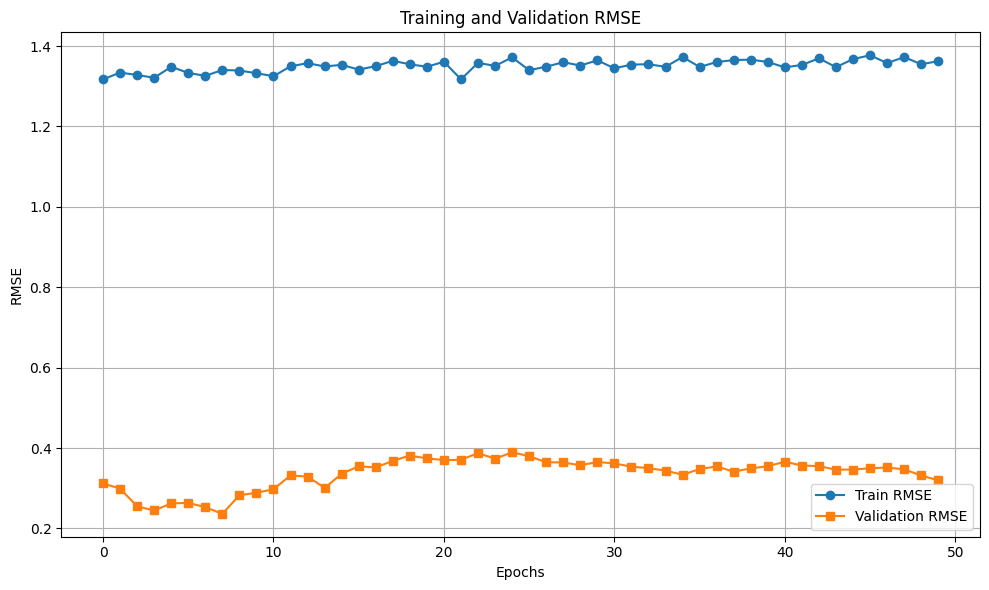

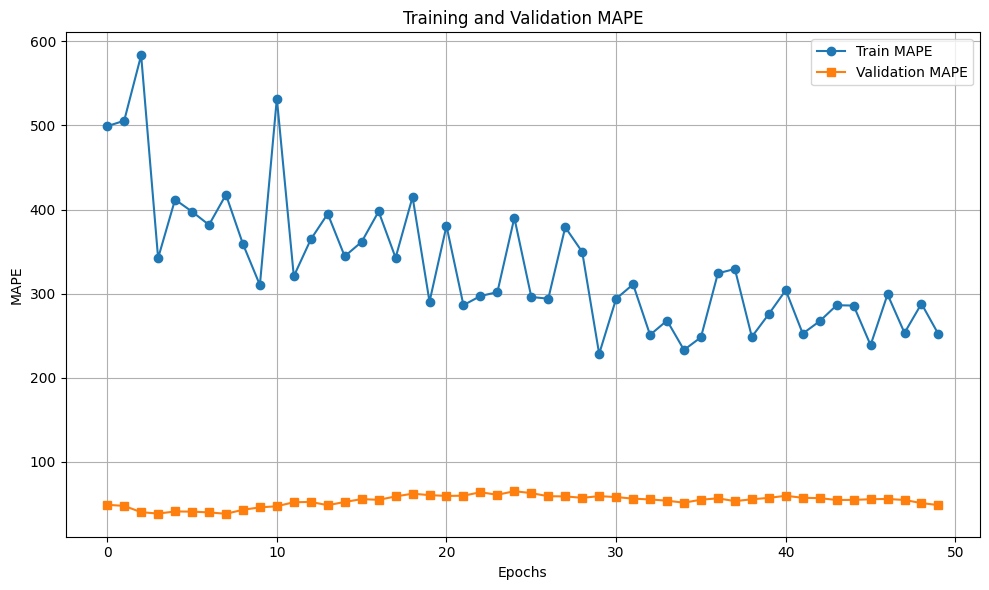

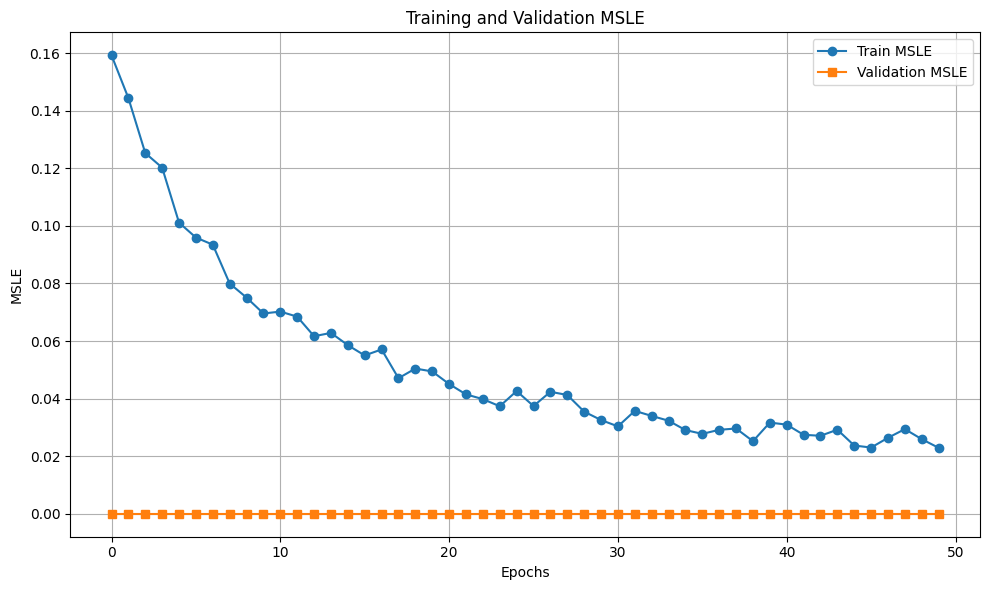

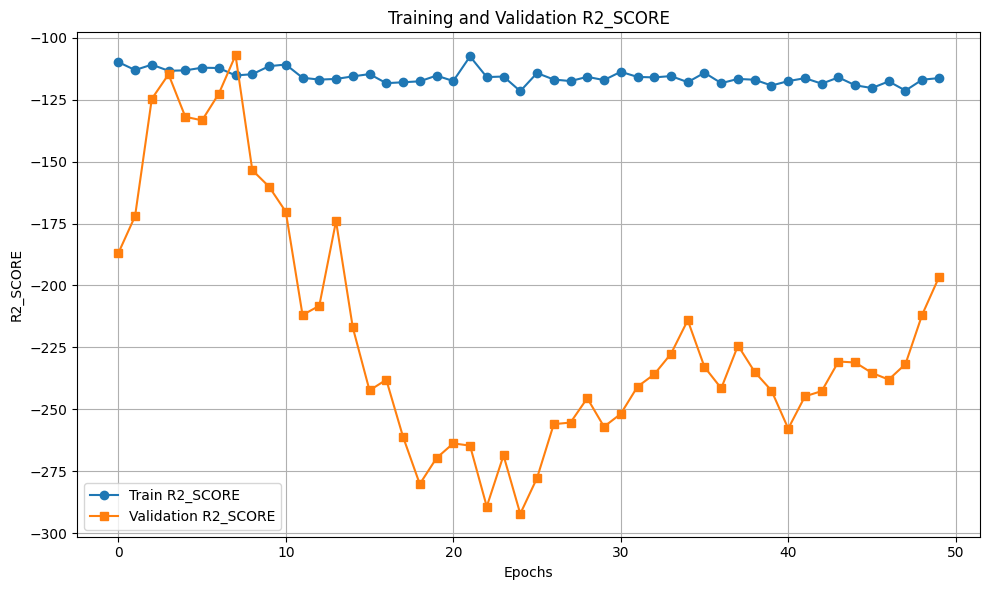

In [62]:
import matplotlib.pyplot as plt

# List of metrics to plot. Make sure these keys exist in history.history.
metrics = ['loss', 'mae', 'rmse', 'mape', 'msle', 'r2_score']

# Loop over each metric and plot training vs. validation curves.
for metric in metrics:
    plt.figure(figsize=(10, 6))
    # Plot training metric
    plt.plot(history.history[metric], label=f"Train {metric.upper()}", marker='o')
    # Plot validation metric if available
    if f"val_{metric}" in history.history:
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric.upper()}", marker='s')
    plt.title(f"Training and Validation {metric.upper()}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()